This notebook shows how to generate synthetic seed-glyphs dataset for our MNIST adventures.
Source of ttf files are aplenty on the interwebs.

Key links:

*  https://www.fontsc.com/font/lohit-kannada
*  https://releases.pagure.org/lohit/
*  http://kannada.indiatyping.com/index.php/download-kannada-font
*  https://fonts.google.com/

In [0]:
from scipy import ndimage
import cv2
import numpy as np

def mnistize_2(img):
    # Function to take in an image and convert it into standard MNIST format
    # Inverse colors and resize to 28x28
#     img = cv2.resize(255-img, (28, 28))
    
    # Binary+Otsu thresholding
    (thresh, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Find tight bounding box for digit
    while np.sum(img[0]) == 0:
        img = img[1:]

    while np.sum(img[:,0]) == 0:
        img = np.delete(img,0,1)

    while np.sum(img[-1]) == 0:
        img = img[:-1]

    while np.sum(img[:,-1]) == 0:
        img = np.delete(img,-1,1)
    rows,cols = img.shape
    
    # Resize image to fit a 20x20 box
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
    img = cv2.resize(img, (cols, rows))
        
    # Pad rows/columns to form 28x28 image
    colsPadding = (int(np.ceil((28-cols)/2.0)), int(np.floor((28-cols)/2.0)))
    rowsPadding = (int(np.ceil((28-rows)/2.0)), int(np.floor((28-rows)/2.0)))
    img = np.lib.pad(img, (rowsPadding,colsPadding), 'constant')
    
    def getBestShift(img):
        cy,cx = ndimage.measurements.center_of_mass(img)

        rows,cols = img.shape
        shiftx = np.round(cols/2.0-cx).astype(int)
        shifty = np.round(rows/2.0-cy).astype(int)

        return shiftx,shifty

    def shift(img,sx,sy):
        rows,cols = img.shape
        M = np.float32([[1,0,sx],[0,1,sy]])
        shifted = cv2.warpAffine(img,M,(cols,rows))
        return shifted

    shiftx, shifty = getBestShift(img)
    img = shift(img, shiftx, shifty)
    
    return img


In [0]:
from google.colab import drive
drive.mount('/gdrive')
import os
os.chdir('/gdrive/My Drive/Colab Notebooks/Uni_MNIST')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
font_dir='/gdrive/My Drive/Colab Notebooks/Uni_MNIST/ttf_files/'
os.listdir(font_dir)

['Lohit-Devanagari.ttf',
 'Lohit-Tamil.ttf',
 'Lohit-Gujarati.ttf',
 'Lohit-Kannada.ttf',
 'Lohit-Malayalam.ttf',
 'WorkSans-Regular.ttf',
 'Kannada',
 'unicode_indic_5.csv',
 'df_uni.csv',
 'df_unicode_sym.csv']

In [0]:
list_files=['Lohit-Kannada.ttf',
 'Lohit-Tamil.ttf',
 'Lohit-Gujarati.ttf',
 'Lohit-Malayalam.ttf',
 'Lohit-Devanagari.ttf']
[l.strip('Lohit-').strip('.ttf') for l in list_files]

['Kannada', 'Tamil', 'Gujarati', 'Malayalam', 'Devanagari']

In [0]:
lang_list=['Kannada', 'Tamil', 'Gujarati', 'Malayalam', 'Devanagari']


In [0]:
from PIL import Image,ImageFont, ImageDraw
import numpy as np

def num2image(i,lang,viz=False):
  # Function to ingest a number and a language and spit out an MNIST sized image
  # using the ttf file

  image = Image.new('L', (28, 28))
  draw = ImageDraw.Draw(image)
  # use a truetype font
  if (lang == 'English'):
    ttf_file='WorkSans-Regular.ttf'
  else:
    ttf_file='Lohit-'+lang+'.ttf'
  ttf_path=os.path.join(font_dir,ttf_file)
  if((lang=='Tamil') | (lang=='Malayalam')):
    font_size=17
    offset=6
  else:
    font_size=25
    offset=7
  font = ImageFont.truetype(ttf_path, font_size)
  draw.text((offset, 1),i, font=font,fill=(255))  
 
  if(viz):
    plt.imshow(np.array(image))
    plt.title(i)
    plt.axis('off')
  return np.array(image)



In [0]:
import pandas as pd
df=pd.read_csv(os.path.join(font_dir,'df_unicode_sym.csv'))
df.head()

,num,unicode,glyph,language
0,0,0CE6,೦,Kannada
1,1,0CE7,೧,Kannada
2,2,0CE8,೨,Kannada
3,3,0CE9,೩,Kannada
4,4,0CEA,೪,Kannada


In [0]:
dict_seeds=dict.fromkeys(lang_list)
for k in dict_seeds.keys():
  dict_seeds[k]=np.zeros((10,28,28))
import matplotlib.pyplot as plt

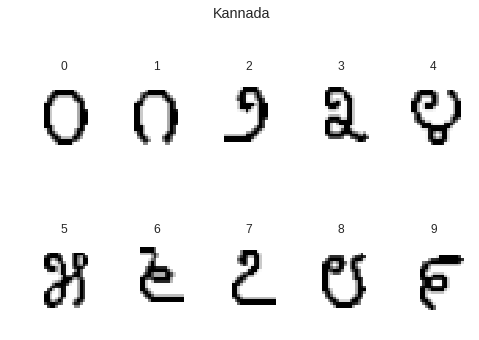

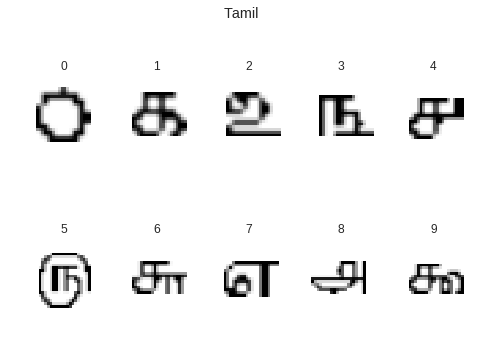

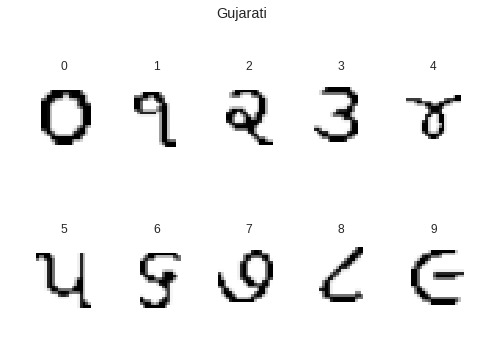

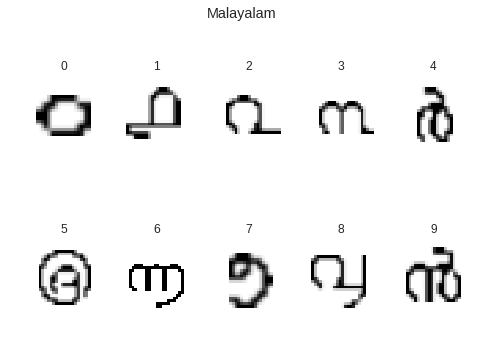

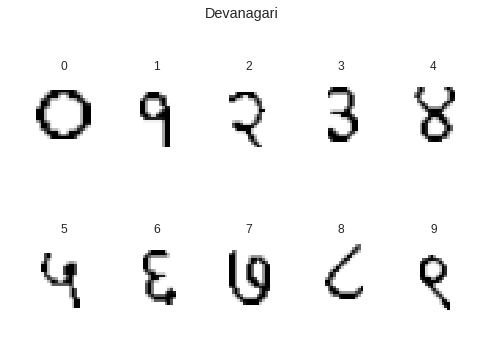

In [0]:
for i in range(10):
  for lang in lang_list:
    glyph_i_lang=df.query('language==@lang and num==@i')['glyph'].values[0]   
    dict_seeds[lang][i,:,:]=mnistize_2(num2image(glyph_i_lang,lang,viz=False))
#Visualization:
import matplotlib.pyplot as plt
for lang in lang_list:
  plt.figure()
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(dict_seeds[lang][i,:,:])
    plt.title(i)
    plt.axis('off')

  plt.suptitle(lang);

# Sanity check:
Now, test using the off-the-shelf MNIST model obtained by training from here:
https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


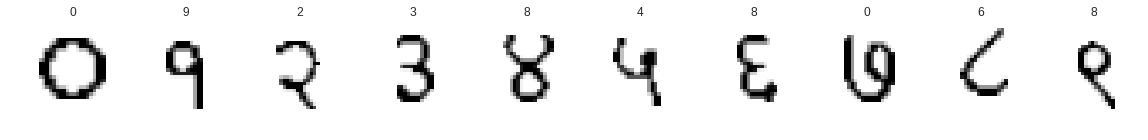

In [0]:
from keras.models import load_model

model=load_model('cnn_mnist.h5')




for i in range(10):
  glyph_i_lang=df.query('language==@lang and num==@i')['glyph'].values[0]   
  dict_seeds[lang][i,:,:]=mnistize_2(num2image(glyph_i_lang,'Devanagari',viz=False))
    
    
x_sanity_check=dict_seeds['Devanagari']
x_sanity_check=np.expand_dims(x_sanity_check,axis=3)
# x_sanity_check=x_sanity_check.astype('float32')#/255
y_sanity_check=model.predict_classes(x_sanity_check)

plt.figure(figsize=(20,20))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(x_sanity_check[i,:,:,0])
  plt.title(y_sanity_check[i])
  plt.axis('off')

Neat. Now save the dictionary of tensors:

In [0]:
np.save('dict_seeds.npy',dict_seeds)